In [ ]:
pip -q install transformers datasets #wandb

     |████████████████████████████████| 3.4 MB 5.2 MB/s 
     |████████████████████████████████| 306 kB 45.6 MB/s 
     |████████████████████████████████| 3.3 MB 54.7 MB/s 
     |████████████████████████████████| 596 kB 31.8 MB/s 
     |████████████████████████████████| 895 kB 56.3 MB/s 
     |████████████████████████████████| 61 kB 466 kB/s 
     |████████████████████████████████| 1.1 MB 53.6 MB/s 
     |████████████████████████████████| 243 kB 47.7 MB/s 
     |████████████████████████████████| 132 kB 12.0 MB/s 
     |████████████████████████████████| 192 kB 54.7 MB/s 
     |████████████████████████████████| 271 kB 58.0 MB/s 
     |████████████████████████████████| 160 kB 57.7 MB/s 


In [ ]:
!nvidia-smi

Wed Dec 29 21:38:58 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P0    29W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# load tensorboard extension
%load_ext tensorboard

# The Task 

<ul>
  <li>
  <b>Subtask 1:</b> Binary classification. Given a paragraph, a system must predict whether or not it contains any form of PCL. 
  </li>
  <li>
  <b>Subtask 2:</b> Multi-label classification. Given a paragraph, a system must identify which PCL categories express the condescension*. 
  </li>
</ul>

Baselines from [the paper](https://arxiv.org/pdf/2011.08320.pdf):


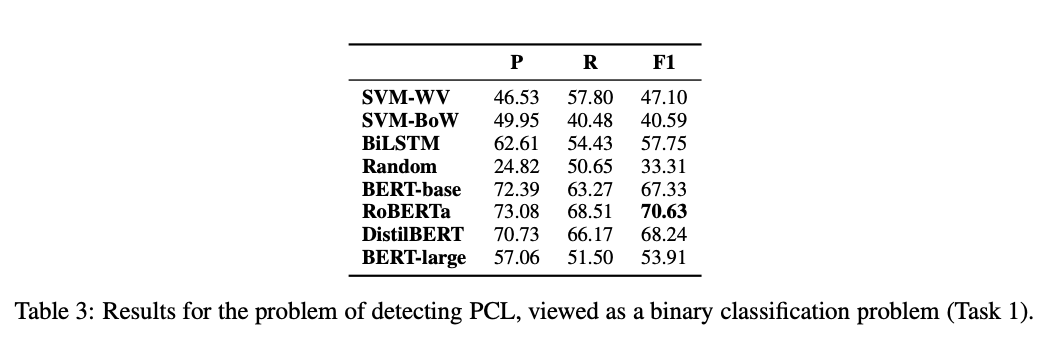


## Prepare Dataset

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
#Skip the disclaimer at the beginning of file
df_pcl = pd.read_csv('/content/dontpatronizeme_pcl.tsv', sep='\t', skiprows=4, header=None)
#delete first columnof dataframe
df_pcl = df_pcl.iloc[: , 1:]
#Name columns
df_pcl.columns = ['paragraph_id',	'keyword', 'country_code',	'paragraph', 'label']
df_pcl

FileNotFoundError: ignored

In [ ]:
df_pcl = df_pcl.dropna().reset_index()
len(df_pcl)

10468

##maximum length

In [ ]:
maxi = 0
for i in range(10468):
  maxi2 = len(df_pcl['paragraph'][i])
  maxi = max(maxi, maxi2)
maxi

5493

In [ ]:
null_data = df_pcl[df_pcl.isnull().any(axis=1)]
null_data

,paragraph_id,keyword,country_code,paragraph,label
8639,@@16852855,migrant,ke,NaN,0


In [ ]:
#df_pcl[df_pcl['paragraph'].duplicated()].iloc[0]['paragraph']
df_pcl['paragraph'].duplicated().any()
df_pcl['paragraph'].duplicated().value_counts()

False    10468
Name: paragraph, dtype: int64

In [ ]:
df_pcl['paragraph_id'].duplicated().value_counts()

False    10092
True       376
Name: paragraph_id, dtype: int64

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


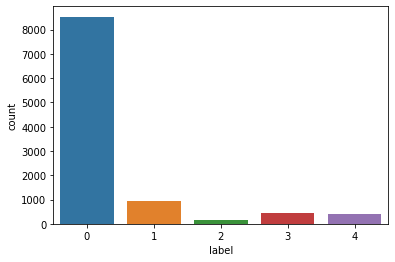

In [ ]:
import seaborn as sns
sns.countplot(df_pcl['label']);

## Binary Classification


In [ ]:
# import os
# os.environ['WANDB_PROJECT'] = 'pcl-binary'

In [ ]:
import torch
from tqdm.notebook import tqdm

from transformers import RobertaTokenizer, BertTokenizer
from torch.utils.data import TensorDataset

from transformers import RobertaForSequenceClassification, BertForSequenceClassification

import seaborn as sns

From [the paper](https://arxiv.org/pdf/2011.08320.pdf):


> for Task 1 we view paragraphs labelled with 0 or 1 as negative examples, and the remaining paragraphs, labelled with 2, 3 or 4, as positive examples



In [ ]:
df_pcl['label'].replace({1:0, 2:1, 3:1, 4:1}, inplace=True)
df_pcl

/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:4582: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  method=method,


,paragraph_id,keyword,country_code,paragraph,label
0,@@24942188,hopeless,ph,"We 're living in times of absolute insanity , ...",0
1,@@21968160,migrant,gh,"In Libya today , there are countless number of...",0
2,@@16584954,immigrant,ie,White House press secretary Sean Spicer said t...,0
3,@@7811231,disabled,nz,Council customers only signs would be displaye...,0
4,@@1494111,refugee,ca,""" Just like we received migrants fleeing El Sa...",0
...,...,...,...,...,...
10464,@@14297363,women,lk,Sri Lankan norms and culture inhibit women fro...,0
10465,@@70091353,vulnerable,ph,He added that the AFP will continue to bank on...,0
10466,@@20282330,in-need,ng,""" She has one huge platform , and information ...",1
10467,@@16753236,hopeless,in,""" Anja Ringgren Loven I ca n't find a word to ...",1


##The PCL dataset contains 9475 notPCL and 993 PCL paragraph.
I think the dataset is not well balanced.

In [ ]:
df_pcl.groupby('label').size()

label
0    9475
1     993
dtype: int64

In [ ]:
# df_pcl_selected = df_pcl
# def combine_features(row) :
#   return '<s>'.join(row.drop(['labels','label'],axis=0).apply(str).values)
# df_pcl_selected['combined_features'] = df_pcl_selected.apply(combine_features, axis = 1)
# # df_pcl_selected = df_pcl_selected[['combined_features','labels']]
# df_pcl_selected

In [ ]:
# valid_size = 1000
# duplicate = df_pcl_selected[df_pcl['paragraph'].duplicated()]
# none_duplicate = df_pcl_selected.drop(duplicate.index, axis=0)
# df_pcl_valid = none_duplicate.sample(valid_size, random_state = 42)
# df_pcl_train = df_pcl_selected.drop(df_pcl_valid.index, axis=0)
# df_pcl_train.iloc[0]['paragraph']


df_pcl_selected = df_pcl[['paragraph', 'label']]
valid_size = 1000
df_pcl_valid = df_pcl_selected.sample(valid_size, random_state = 42)
df_pcl_train = df_pcl_selected.drop(df_pcl_valid.index, axis=0)
df_pcl_train, df_pcl_valid

(                                               paragraph  label
 0      We 're living in times of absolute insanity , ...      0
 1      In Libya today , there are countless number of...      0
 2      White House press secretary Sean Spicer said t...      0
 4      " Just like we received migrants fleeing El Sa...      0
 5      To bring down high blood sugar levels , insuli...      0
 ...                                                  ...    ...
 10463  When Marie O'Donoghue went looking for a speci...      0
 10464  Sri Lankan norms and culture inhibit women fro...      0
 10465  He added that the AFP will continue to bank on...      0
 10466  " She has one huge platform , and information ...      1
 10467  " Anja Ringgren Loven I ca n't find a word to ...      1
 
 [9468 rows x 2 columns],
                                               paragraph  label
 7565  Ekso -- formerly known as Berkeley Bionics -- ...      0
 5262  Thirty seven percent of the offences registere...      0


### Text Augmentation

In [ ]:
import os
os.environ["MODEL_DIR"] = '../model'

In [ ]:
!pip install nlpaug

     |████████████████████████████████| 410 kB 5.3 MB/s 
     |████████████████████████████████| 11.3 MB 44.0 MB/s 
  Attempting uninstall: pandas
    Found existing installation: pandas 1.1.5
    Uninstalling pandas-1.1.5:
      Successfully uninstalled pandas-1.1.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas~=1.1.0; python_version >= "3.0", but you have pandas 1.3.5 which is incompatible.


In [ ]:
import nlpaug.augmenter.char as nac
import nlpaug.augmenter.word as naw
import nlpaug.augmenter.sentence as nas
import nlpaug.flow as nafc

from nlpaug.util import Action

In [ ]:
back_translation_aug = naw.BackTranslationAug(
    from_model_name='facebook/wmt19-en-de', 
    to_model_name='facebook/wmt19-de-en'
)

Downloading:   0%|          | 0.00/825 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.00G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/825 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.00G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/67.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/829k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/829k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/308k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/67.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/829k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/829k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/308k [00:00<?, ?B/s]

In [ ]:
def back_translate(paragraph) :
  return back_translation_aug.augment(paragraph)

In [ ]:
new_pcl = df_pcl_train[df_pcl_train['label'] == 1].reset_index()
for index, row in new_pcl.iterrows() :
  if len(row['paragraph']) > 1024 :
    new_pcl.drop(index, axis = 0)

In [ ]:
new_pcl['paragraph'] = new_pcl['paragraph'].apply(back_translate)

In [ ]:
new_pcl.iloc[0]['paragraph']

'Bond did everything he could to help the less fortunate, often taking to the streets with Kim to bring food to the homeless.'

In [ ]:
df_pcl_train[df_pcl_train['labels'] == 1].iloc[0]['paragraph']

'Bond went out of his way to help the less fortunate , often going on the road with Kim to take food to the homeless .'

In [ ]:
new_pcl.to_csv('/content/pcl_augmented.tsv')

### Loading The Augmented Paragraphs

In [ ]:
augmented_pcl = pd.read_csv('/content/pcl_augmented.csv')
augmented_pcl = augmented_pcl.drop(['combined_features','index'], axis = 1)

In [ ]:
augmented_pcl['combined_features'] = augmented_pcl.apply(combine_features, axis = 1)

In [ ]:
augmented_pcl

,paragraph_id,keyword,country_code,paragraph,label,labels,combined_features
0,@@4521109,homeless,jm,Bond did everything he could to help the less ...,4,1,@@4521109<s>homeless<s>jm<s>Bond did everythin...
1,@@416767,hopeless,ca,"John Donovan, director of the Addiction Founda...",3,1,"@@416767<s>hopeless<s>ca<s>John Donovan, direc..."
2,@@16569964,poor-families,gh,Xi made the comments during a visit to Zhangji...,4,1,@@16569964<s>poor-families<s>gh<s>Xi made the ...
3,@@4675022,homeless,my,One tramp even told me that he never wanted to...,4,1,@@4675022<s>homeless<s>my<s>One tramp even tol...
4,@@19065409,poor-families,jm,As we poor families in England watch them writ...,4,1,@@19065409<s>poor-families<s>jm<s>As we poor f...
...,...,...,...,...,...,...,...
845,@@4661628,homeless,pk,This longing for homelessness is the fate of m...,3,1,@@4661628<s>homeless<s>pk<s>This longing for h...
846,@@4542224,homeless,my,Most of them (the homeless) have the ability t...,3,1,@@4542224<s>homeless<s>my<s>Most of them (the ...
847,@@14011977,refugee,pk,Hundreds of thousands of internally displaced ...,3,1,@@14011977<s>refugee<s>pk<s>Hundreds of thousa...
848,@@23275174,disabled,gh,Motsepe and his wife Precious founded the Mots...,4,1,@@23275174<s>disabled<s>gh<s>Motsepe and his w...


In [ ]:
augmented_train = pd.concat([df_pcl_train,augmented_pcl]).sample(frac=1)
augmented_train

,paragraph_id,keyword,country_code,paragraph,label,labels,combined_features
989,@@15228148,refugee,ke,JUBA South Sudan ( Xinhua ) --The UN refugee a...,0,0,@@15228148<s>refugee<s>ke<s>JUBA South Sudan (...
48,@@24134544,homeless,gh,She founded Royal Seed to raise a child who is...,4,1,@@24134544<s>homeless<s>gh<s>She founded Royal...
7856,@@4743061,disabled,au,"Then , in the 1960s , the most un/popular disa...",0,0,"@@4743061<s>disabled<s>au<s>Then , in the 1960..."
4555,@@25519044,immigrant,za,Tuesday 's shooting inflamed already simmering...,0,0,@@25519044<s>immigrant<s>za<s>Tuesday 's shoot...
5631,@@1921093,in-need,tz,He would look into your computer or electronic...,0,0,@@1921093<s>in-need<s>tz<s>He would look into ...
...,...,...,...,...,...,...,...
1163,@@24197546,in-need,ie,The last time a justice secretary sacked an of...,0,0,@@24197546<s>in-need<s>ie<s>The last time a ju...
5353,@@20703190,homeless,pk,"Similarly , the Tehsil Headquarters Hospital t...",0,0,"@@20703190<s>homeless<s>pk<s>Similarly , the T..."
3652,@@14028752,in-need,gh,"At a ceremony held in Accra , she said the pre...",3,1,@@14028752<s>in-need<s>gh<s>At a ceremony held...
3304,@@3205242,migrant,au,Italy scaled back the mission after failing to...,0,0,@@3205242<s>migrant<s>au<s>Italy scaled back t...


## Training using Huggingface API

In [ ]:
from datasets import Dataset
raw_datasets_valid = Dataset.from_pandas(df_pcl_valid[['combined_features','labels']])
raw_datasets_train = Dataset.from_pandas(augmented_train[['combined_features','labels']])
raw_datasets_train

Dataset({
    features: ['combined_features', 'labels', '__index_level_0__'],
    num_rows: 9908
})

Because the labels are imbalanced, we split the data set in a stratified fashion, using this as the class labels.

In [ ]:
# FIXME: Ali - Idea: Try zero shot, few shot, fine-tuning with GPT-3
from transformers import AutoTokenizer
model_name = 'roberta-large'
# model_name = 'bert-base-uncased'
# model_name = 'roberta-large-openai-detector' #FIXME: Ali - Idea: Try other larger models
tokenizer = AutoTokenizer.from_pretrained(model_name)

Downloading:   0%|          | 0.00/482 [00:00<?, ?B/s]

/usr/local/lib/python3.7/dist-packages/transformers/configuration_utils.py:337: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  "Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 "


Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.29M [00:00<?, ?B/s]

In [ ]:
def tokenize_function(examples):
    return tokenizer(examples["combined_features"], padding="max_length", truncation=True)

tokenized_datasets_train = raw_datasets_train.map(tokenize_function, batched=True)
tokenized_datasets_valid = raw_datasets_valid.map(tokenize_function, batched=True)
tokenized_datasets_train

  0%|          | 0/10 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

Dataset({
    features: ['__index_level_0__', 'attention_mask', 'combined_features', 'input_ids', 'labels'],
    num_rows: 9908
})

In [ ]:
small_dataset_size = 10
small_train_dataset = tokenized_datasets_train.shuffle(seed=42).select(range(small_dataset_size))
small_eval_dataset = tokenized_datasets_valid.shuffle(seed=42).select(range(small_dataset_size))
full_train_dataset = tokenized_datasets_train
full_eval_dataset = tokenized_datasets_valid

In [ ]:
# model_bert = AutoModelForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)
# model_bert

In [ ]:
# model_bert()

In [ ]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

/usr/local/lib/python3.7/dist-packages/transformers/configuration_utils.py:337: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  "Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 "


Downloading:   0%|          | 0.00/1.33G [00:00<?, ?B/s]

Some weights of the model checkpoint at roberta-large were not used when initializing RobertaForSequenceClassification: ['lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifie

In [ ]:
from datasets import load_metric, list_metrics
# list_metrics()

In [ ]:
from transformers import TrainingArguments
run_name = 'roberta_large_cosine_lr1e-5'
# https://huggingface.co/transformers/main_classes/trainer.html#transformers.TrainingArguments
training_args = TrainingArguments(run_name, num_train_epochs=8, save_total_limit=2, learning_rate=1e-5,
                                  evaluation_strategy= "epoch", per_device_train_batch_size=4, gradient_accumulation_steps=1, warmup_steps=1000, lr_scheduler_type='cosine') 
# , resume_from_checkpoint='full_roberta_lr5e-5' , per_device_train_batch_size=4
# FIXME: Ali - Idea: use schedulers with different learning_rate (higher or lower) 
# TODO: Ali - add Gdrive to save checkpoints in gdrive
# TODO: Ali - use `resume_from_checkpoint` to load model from last checkpoint

In [ ]:
 from transformers import Trainer
import numpy as np
# from datasets import load_metric

# f1_metric = load_metric('f1')

# accuracy_metric = load_metric("accuracy")

In [ ]:
# model.roberta.encoder

In [ ]:
# df_pcl_valid['labels'].values[:10]

In [ ]:
# f1_metric.compute(predictions=y_pred.predictions.argmax(axis=1), references=df_pcl_valid['labels'].values[10:20])

In [ ]:
from sklearn.metrics import f1_score
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = logits.argmax(axis=-1)
    return {'f1': f1_score(labels, predictions, average='macro')}
    # return f1_metric.compute(predictions=predictions, references=labels)

trainer = Trainer(
    model=model, args=training_args,
    train_dataset=full_train_dataset,
    eval_dataset=full_eval_dataset,
    compute_metrics=compute_metrics,
)

In [ ]:
!nvidia-smi

Tue Sep 28 21:37:20 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.63.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    33W / 250W |   2277MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
# Wandb accces code: 6eac997ed11cad663510778e5e1c33388cdac6c5
# swswswswswswswsw

In [ ]:
# import gc
# gc.collect()
# torch.cuda.empty_cache()
os.environ["WANDB_DISABLED"] = "true"

In [ ]:
trainer.train()

The following columns in the training set  don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: combined_features, __index_level_0__.
***** Running training *****
  Num examples = 9908
  Num Epochs = 8
  Instantaneous batch size per device = 4
  Total train batch size (w. parallel, distributed & accumulation) = 4
  Gradient Accumulation steps = 1
  Total optimization steps = 19816
/usr/local/lib/python3.7/dist-packages/transformers/configuration_utils.py:337: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  "Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 "


Epoch,Training Loss,Validation Loss,F1
1,0.413400,0.531362,0.474790
2,0.328700,0.457580,0.704521
3,0.169500,0.489500,0.712914
4,0.080200,0.676933,0.709449
5,0.017500,0.758015,0.701040
6,0.027700,0.872361,0.730376
7,0.009500,0.941153,0.734311
8,0.000000,0.963250,0.726424


Saving model checkpoint to roberta_large_cosine_lr1e-5/checkpoint-500
Configuration saved in roberta_large_cosine_lr1e-5/checkpoint-500/config.json
Model weights saved in roberta_large_cosine_lr1e-5/checkpoint-500/pytorch_model.bin
Saving model checkpoint to roberta_large_cosine_lr1e-5/checkpoint-1000
/usr/local/lib/python3.7/dist-packages/transformers/configuration_utils.py:337: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  "Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 "
Configuration saved in roberta_large_cosine_lr1e-5/checkpoint-1000/config.json
Model weights saved in roberta_large_cosine_lr1e-5/checkpoint-1000/pytorch_model.bin
Saving model checkpoint to roberta_large_cosine_lr1e-5/checkpoi

TrainOutput(global_step=19816, training_loss=0.13415020088343882, metrics={'train_runtime': 18236.0642, 'train_samples_per_second': 4.347, 'train_steps_per_second': 1.087, 'total_flos': 7.38686075828306e+16, 'train_loss': 0.13415020088343882, 'epoch': 8.0})

In [ ]:
trainer.evaluate()

In [ ]:
y_pred = trainer.predict(small_eval_dataset)

In [ ]:
y_pred.predictions.argmax(axis=1)

In [ ]:
df_preds=pd.DataFrame(y_pred.label_ids)
df_preds

In [ ]:
# del trainer
# import gc
# gc.collect()
# torch.cuda.empty_cache()

In [ ]:
# For WandB results checkout https://wandb.ai/alipanahi/pcl-binary 
%tensorboard --logdir "roberta_large_lr5e-5"

In [ ]:
# mkdir -p /content/drive/MyDrive/full_roberta_lr5e-5/checkpoint-5500/

In [ ]:
# cp -r /content/full_roberta_lr5e-5/checkpoint-5500/ /content/drive/MyDrive/full_roberta_lr5e-5/checkpoint-5500/

In [ ]:
# import wandb
# wandb.init(project='pcl-binary')

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(df_pcl_valid['labels'].values, df_preds.values, target_names=['0','1']))

In [ ]:
from sklearn.metrics import f1_score
f1_score(df_pcl_valid['labels'].values, df_preds.values, average='macro')

In [ ]:
df_pcl_valid['labels'].values[:10]